# The pyabf Cookbook: Membrane Test Theory
_Code examples demonstrating how to calculate holding current (Ih), membrane resistance (Rm), access resistance (Ra), and membrane capacitance (Cm) of a neuron by inspecting the current responses to voltage changes using voltage-clamp mode and whole-cell configuration._

For more resources, see the pyABF project website: http://www.GitHub.com/swharden/pyABF

### Prepare the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3)

### Prepare a sample membrane test recording (`memtest.npy`)
Let's use the first several thousand data points from a voltage-clamp recording which has a step in the beginning. For simplicity (in case you're interested in learning how to calculate membrane properties _not_ relying on the pyABF module), I'll save some data as a npy file. Anyone can open it with python.

In [2]:
try:
    print("briefly using pyabf to generate some data...")
    import sys
    sys.path.insert(0, '../src/')
    import pyabf
    abf=pyabf.ABF(R"../data/16d05007_vc_tags.abf")
    data=abf.dataY[:7000]
    np.save("memtest.npy",data)
    del abf
    del pyabf
    print("pyabf (and the ABF object we created) are now deleted!")
except:
    print("Could not load the pyabf package, and that's okay!")
    print("Data from memtest.npy will be used for this example...")

briefly using pyabf to generate some data...
pyabf (and the ABF object we created) are now deleted!


### Load a sample membrane test recording (`memtest.npy`)
Let's load some sample data and inspect it. This is part of a real recording where the voltage clamp went from -70 mV to -80 mV and back.

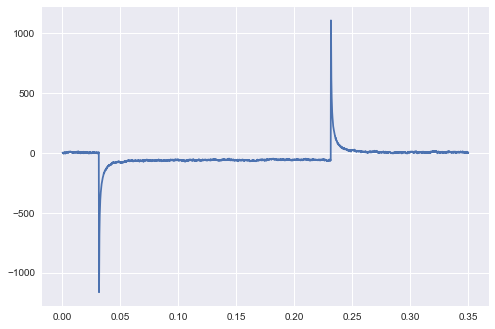

In [3]:
data=np.load("memtest.npy")
rate=20000 # 20 kHz sample rate
times=np.arange(len(data))/rate
plt.plot(times,data);

## Separate data by epoch

* In this example, the points are hard coded
* Using pyabf, epoch start points are defined in `abf.epochStartPoint`

In [4]:
stepI1=626
stepI2=stepI1+4000

data1=data[:stepI1]
data2=data[stepI1:stepI2]
data3=data[stepI2:]

## Calculate steady-state currents (and Ih)

Although the first bit after a voltage step is dominated by a capacitive transient, the steady state current for each voltage step can be measured by averaging the last 50% of each section.

Although the pre-epoch segment could be used to determine Ih, a more ideal way is to use epoch A as your voltage step and make epoch B a reversion to your holding voltage. This will produce a longer segment allowing more time for averaging.

In [5]:
mean1=np.average(data1) # average the whole step
mean2=np.average(data2[int(-len(data2)/2):]) # average just the last 50% of the step
mean3=np.average(data3[int(-len(data3)/2):]) # average just the last 50% of the step
print("step means:",mean1,mean2,mean3)

Ih=mean3 # this is longer (more accurate) than the smaller pre-epoch piece of data
print("holding current (Ih):",Ih)

step means: 2.16587 -59.7438 4.38137
holding current (Ih): 4.38137


Let's look graphically at our calculated means

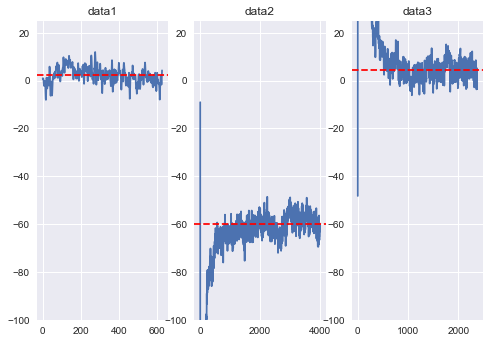

In [6]:
ax1=plt.subplot(131)
plt.plot(data1)
plt.axhline(mean1,color='r',ls='--')
plt.title("data1")

plt.subplot(132,sharey=ax1)
plt.plot(data2)
plt.axhline(mean2,color='r',ls='--')
plt.title("data2")

plt.subplot(133,sharey=ax1)
plt.plot(data3)
plt.axhline(mean3,color='r',ls='--')
plt.title("data3")

plt.axis([None,None,-100,25]); # zoom in the interesting area

## Calculate membrane resistance (Rm)

Rm can be calcuated by comparing the means of the step currents (delta I, `dI`) to the change in clamp voltage (delta V, `dV`) that caused it.
* `V=IR`
* `R=V/I`
* `R=dV/dI`

_note: This equation assumes units are V, A, and Ohms_

In [7]:
dV=10 # change in voltage (known from command waveform)
dI=np.abs(mean3-mean2) # change in current (measured)
print("dV: %.02f mV"%dV)
print("dI: %.02f pA"%dI)

Rm=(dV/1e3)/(dI/1e12) # mV to V and pA to A
Rm=Rm/1e6 # Ohm to MOhm
print("Rm: %.02f MOhm"%Rm)

dV: 10.00 mV
dI: 64.13 pA
Rm: 155.95 MOhm


## Estimate access resistance (Ra) by reporting the peak transient
To measure Ra you need to first calculate membrane capacitance (Cm). That's a lot of work. If you want to assess cell stability without going through all the work (and computational time) of calculating Cm, you could just report the average transient size. An abrupt change in Ra will change this size, so it's a good indicator of stability over long-duration experiments.

In [8]:
peak1=np.abs(np.min(data2)-mean2)
peak2=np.abs(np.max(data3)-mean3)
peakTransient=np.average((peak1,peak2))
print("peak transient: %.02f pA"%peakTransient)

Ra=(dV*1e-3)/(peakTransient*1e-12)
Ra=Ra/1e6 # convert to MOhm units
print("Ra: %.02f MOhm"%Ra)

peak transient: 1102.64 pA
Ra: 9.07 MOhm


## Calculate tau (membrane time constant)

### EnsureSciPy is available
_This isn't a given, since SciPy is massively huge and difficult to compile on some systems._

In [9]:
try:
    import scipy.optimize
except ModuleNotFoundError:
    print("Scipy is not installed. Cm will not be calculated.")

### Create an ideal curve
Rather than calculate tau twice (one for the step down, another for the step up) let's average the two together. This can be done by centering them at 0 (subtracing out their steady-state currents) and averaging them together.

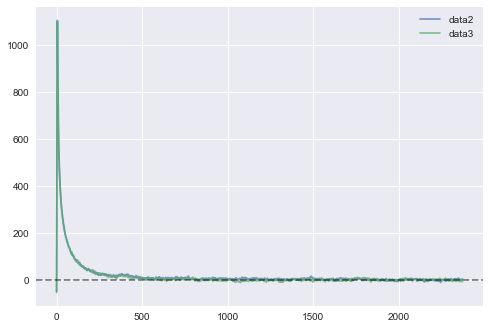

In [10]:
chunkSize=np.min((len(data2),len(data3)))
chunks=np.empty((2,chunkSize)) # will hold both chunks

chunks[0]=-(data2[:chunkSize]-mean2) # invert data 2
chunks[1]=data3[:chunkSize]-mean3

plt.plot(chunks[0],alpha=.7,label="data2")
plt.plot(chunks[1],alpha=.7,label="data3")
plt.axhline(0,ls='--',color='k',alpha=.5);
plt.legend();

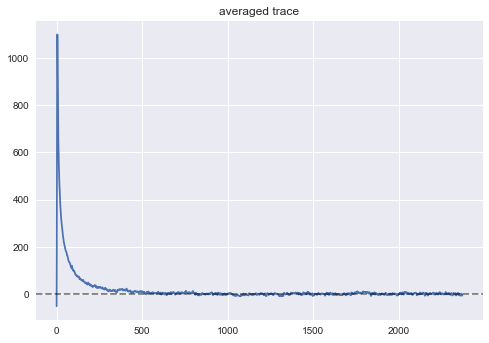

In [11]:
#trace=np.average(chunks,axis=0)
trace=chunks[1]
plt.plot(trace)
plt.axhline(0,ls='--',color='k',alpha=.5);
plt.title("averaged trace");

### Trim-out the rising phase

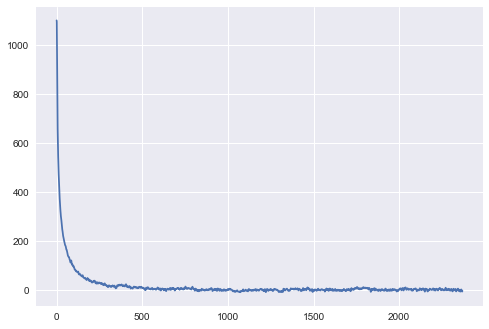

In [12]:
tracePeak=np.max(trace)
traceIndex=np.where(trace==tracePeak)[0]
trace=trace[int(traceIndex):]
plt.plot(trace);

### Determine the area of the curve to measure
In an ideal world you'd fit between 80% and 20% (relative to peak and steady state). In reality the hardware low-pass filtering will really mess you up on data values which change quickly. This especially disorts the top-half of the curve. For this reason, I prefer to fit the lower portion of the curve.

1100.59899902


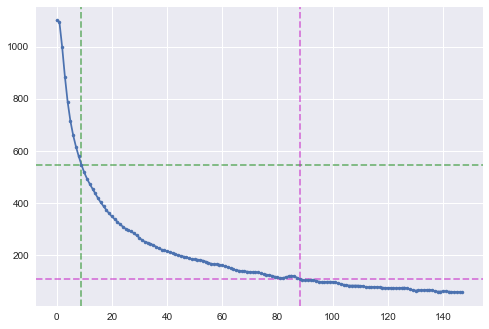

In [13]:
def firstIndexBelow(data,target):
    """returns the first index of an array below a given value."""
    for i,val in enumerate(data):
        if val<target:
            return i
    return None

print(tracePeak)
iTop=firstIndexBelow(trace,tracePeak*.5)
iBot=firstIndexBelow(trace,tracePeak*.1)

# let's trim-off data less than 10% of the peak
iEnd=firstIndexBelow(trace,tracePeak*.05)
trace=trace[:iEnd]

plt.axhline(trace[iTop],color='g',ls='--',alpha=.5)
plt.axhline(trace[iBot],color='m',ls='--',alpha=.5)
plt.axvline(iTop,color='g',ls='--',alpha=.5)
plt.axvline(iBot,color='m',ls='--',alpha=.5)
plt.plot(trace,'.-');

### Isolate just the points you want to fit

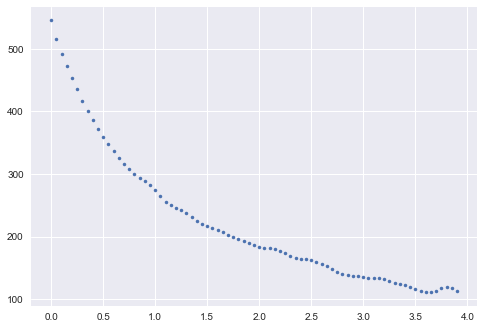

In [14]:
fitThis=trace[iTop:iBot]
x=np.arange(len(fitThis))/rate*1000 # ms units
plt.plot(x,fitThis,'.');

### Prepare mono-exponential function to fit against

In [15]:
def algoMonoExp(x, m, t, b):
    return m*np.exp(-t*x)+b

### Perform the curve fit

_note: This requires SciPy. Add a function that does this without SciPy and you can omit the entire package!_

In [16]:
params, cv = scipy.optimize.curve_fit(algoMonoExp, x, fitThis, p0=(1,1e-6,1))
m,t,b=params

### Assess the fit

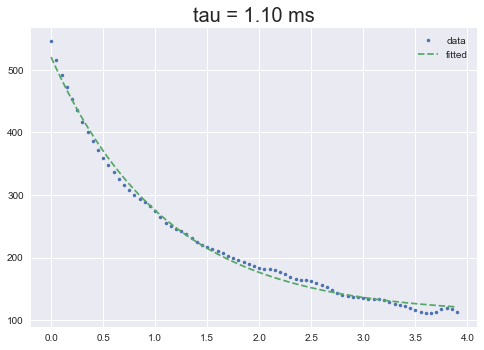

In [17]:
plt.plot(x,fitThis,'.',label="data")
plt.plot(x,algoMonoExp(x,m,t,b),'--',label="fitted")
plt.legend()
tau=1/t
plt.title("tau = %.02f ms"%tau,fontsize=20);

## Calculate Cm from tau
Membrane capacitance (Cm) is just tau (sec) / Ra (Ohms)

In [18]:
Cm=((tau*1e-3)/(Ra*1e6))*1e12 # pF
print("Cm: %.02f pF"%Cm)

Cm: 121.72 pF


We now have all intrinsic membrane properties for this sweep:

In [19]:
print("Ih: %.02f pA"%(Ih))
print("Rm: %.02f MOhm"%(Rm))
print("Ra: %.02f MOhm"%(Ra))
print("Cm: %.02f pF"%(Cm))

Ih: 4.38 pA
Rm: 155.95 MOhm
Ra: 9.07 MOhm
Cm: 121.72 pF



## Comparison to CJFLab
At my workplace, customized closed-source software written by CJF (called CJFLab) is frequently used to calculate cellular membrane properties from arbitrary voltage steps. Here we compare the values calculated here against those calculated with CJFLab. Note that for CJFLab, membrane test settings were adjusted to reflect a 50% - 10% from-peak decay range. In this table, IPython represents values obtained from this script.

metric | IPython | CJFLab
---|---|---
Ih|4.38|2.17
Rm|155.95|156.44
Ra|9.07|8.87
Cm|125.14|143.07

Note that the method here is distinctly different than that employed by CJFLab, namely in that it curve-fits two curves which have been averaged together. To see how much this may influence the measurements, I re-ran code from this script three times to reflect the difference of averaging across multiple transients.
* first transient only: 127.11 pF
* second transient only: 121.72 pF
* both transients averaged: 125.14 pF

_Afterthought: ClampEx's memtest values are also distinctly different than those reported by CJFLab. This is especially true when reporting capacitance. I would be especially interested to know if my values are closer to those reported by Clampex._

## Alternative methods to calculate cell capacitance (Cm)
All discussion and code examples up to this point have attempted to calculate capacitance from a voltage step by inspecting the transient. This method uses an abrupt voltage step to cause a capacitive transient in the current trace, and attempts to extract a decay constant from the transient and work from there. Limitations of this method stem from the fact that the transient is extremely fast:

### Disadvantages of the voltage-step method

* Transients are very fast and greatly susceptible to distortion by hardware low-pass filter
* Transients are very fast and greatly susceptible to noise
* Fitting the transient data to a curve is computationally complex, slow, and can fail
* An unluckily-timed IPSC or EPSC will destroy a meaningful curve fit

When considering the alternatives, I found it helpful to consider _why_ the transient is of interest to measurements of Cm. Try this thought experiment:

* If a cell had 0 pF capacitance, it would effortlessly swing to any command voltage.
* If a cell had 0 pF capacitance, it would charge/discharge instantly, and it would produce no transient.
* The transient is the voltage-clamp amplifier trying to "catch-up" to the fact the cell has not _charged_ to the command voltage yet.
* A cell with a greater _capacity_ to _charge_ is a cell with a high _capacitance_.
* What we are really measuring in the transient is how long it takes the cell to "catch-up" to the command voltage.

There are other ways to measure _how long it takes the cell to catch-up to the command voltage_, and they are explored in the following sections.

### Alternative method: voltage clamp ramp
* Since cell capacitance relates to how long it takes the cell to catch-up to the command voltage, one clever way of quantifying this effect is to present it with a moving-target command voltage. 
* Unlike a voltage step which the cell equilibrates with in a  few milliseconds, a sliding voltage-clamp ramp leaves the cell voltage / amplifier current slightly below or above equilibrium. 
* If we apply a voltage ramp in the downward direction and then the same ramp in the upward direction, the cell will lag the moving-target clamp voltage by the same amount in opposite directions.
* Membrane capacitance can be calculated from the difference between the doward-ramp and upward-ramp signals.
* Rather than obsess about the initial transient, we want to ignore it completely! We will therefore discard data at the start and end of changes in ramp direction.

In [20]:
#TODO: get data to play with

### Alternative method: current clamp step
An important distinction exists between the voltage-clamp time constant (here called _tau_) and the cell membrane time constant (here called _tauMemb_). They can both be used to infer capacitance, but it is important to understand what they are.

**tau** - _the rate-constant of the current transient to a voltage step_
* a function of the _amplifier/cell configuration_.
* reflects how fast the amplifier can charge/discharge the cell.
* will be a large value (slow time constant) for cells with high capacitance.
* membrane ion conductances do not meaningfully influence this measurement.
* it is used (in combination with series / access resistance) to infer information about size of the cell. 
* because it is a measurement of the amplifier's ability to clamp the voltage of a cell, it is extremely fast.

**tauMemb** - _the rate-constant of the voltage transient to a current step)_
* a true function of the cell membrane
* reflects the "desire" of the cell to rectify its voltage
* stabilization is achieved by ion flux through ion channels (leak and active) in the membrane
* this time constant, in itself, is only indirectly related to capacitance. _(If we knew the exact number of open channels and all their ionic forces, perhaps we could use this value to calculate Cm, but we usually don't, and we usually can't, so we typically don't try)_

In [21]:
#TODO: get data to play with